In [1]:
using OpenCL
using PyPlot

In [2]:
# This will probably be different on your computer
cl.devices()

3-element Array{OpenCL.cl.Device,1}:
 OpenCL.Device(Intel(R) Core(TM) i7-3720QM CPU @ 2.60GHz on Apple @0x00000000ffffffff)
 OpenCL.Device(HD Graphics 4000 on Apple @0x0000000001024400)                         
 OpenCL.Device(GeForce GT 650M on Apple @0x0000000001022700)                          

# Native Julia Julia Set Implementation

In [3]:
w = 2048 * 2;
h = 2048 * 2;
@printf("Size %i MB\n", sizeof(Complex64) * w * h / 1024 / 1024)

Size 128 MB


In [4]:
# julia set
# (the familiar mandelbrot set is obtained by setting c==z initially)
function julia(z, maxiter)
    c = Complex64(-0.5, 0.75)
    for n = 1:maxiter
        if abs2(z) > 4.0
            return n-1
        end
        z = z*z + c
    end
    return maxiter
end

julia (generic function with 1 method)

In [5]:
q = [Complex64(r,i) for i=1:-(2.0/w):-1, r=-1.5:(3.0/h):1.5];

In [6]:
function ordinary_julia(q; maxiter=300)
    (h, w) = size(q)
    m  = Array{UInt8}(h, w);
    for i in 1:w
        for j in 1:h
            @inbounds v = q[j, i]
            @inbounds m[j, i] = julia(v, maxiter)
        end
    end
    return m
end

ordinary_julia (generic function with 1 method)

In [7]:
@time m = ordinary_julia(q; maxiter=300);

  0.438303 seconds (18.13 k allocations: 16.961 MiB)


In [8]:
get_cmap("RdGy")

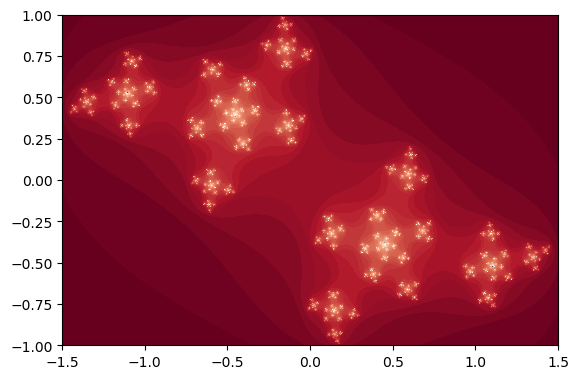

In [9]:
imshow(m, cmap="RdGy", extent=[-1.5,1.5,-1,1]);

In [10]:
julia_solution = deepcopy(m);

# OpenCL GPU Julia Set Implementation

Let us make the previous implementation compatible with OpenCL.  
    

In [11]:
cl.devices()

3-element Array{OpenCL.cl.Device,1}:
 OpenCL.Device(Intel(R) Core(TM) i7-3720QM CPU @ 2.60GHz on Apple @0x00000000ffffffff)
 OpenCL.Device(HD Graphics 4000 on Apple @0x0000000001024400)                         
 OpenCL.Device(GeForce GT 650M on Apple @0x0000000001022700)                          

In [12]:
device = cl.devices()[3]

OpenCL.Device(GeForce GT 650M on Apple @0x0000000001022700)

In [13]:
julia_source = "

__kernel void julia(__global float2 *q,
                    __global ushort *output,
                    ushort const maxiter)
{
 int gid = get_global_id(0);
 float nreal = 0;
 float real  = q[gid].x;
 float imag  = q[gid].y;

 output[gid] = 0;

 for(int curiter = 0; curiter < maxiter; curiter++) {
     if (real*real + imag*imag > 4.0f) {
         output[gid] = curiter;
     }
     nreal = real*real - imag*imag + -0.5f;
     imag  = 2*real*imag + 0.75f;
     real = nreal;
  }
}";

In [14]:
function julia_opencl(q::Array{Complex64}, maxiter::Int64, device)
    ctx   = cl.Context(device)
    queue = cl.CmdQueue(ctx)

    out = Array{UInt16}(size(q))

    q_buff = cl.Buffer(Complex64, ctx, length(q), (:r, :copy), hostbuf=q)
    o_buff = cl.Buffer(UInt16, ctx, length(out), :w)

    prg = cl.Program(ctx, source=julia_source) |> cl.build!
    k = cl.Kernel(prg, "julia")

    queue(k, length(q), nothing, q_buff, o_buff, UInt16(maxiter))
    cl.copy!(queue, out, o_buff)

    return out
end


julia_opencl (generic function with 1 method)

We can verify that the outputs are quite similar

In [15]:
opencl_solution = deepcopy(m);

In [16]:
isapprox(opencl_solution, julia_solution)

true

### OpenCL code portability

We can see that the code is portable but performance is not. If we select as device the CPU even though we are executing the same OpenCL code the performance is not as good.

#### Device 1: Intel i7-3720QM CPU @ 2.60GHz

In [17]:
device = cl.devices()[1]

OpenCL.Device(Intel(R) Core(TM) i7-3720QM CPU @ 2.60GHz on Apple @0x00000000ffffffff)

In [18]:
@time m = julia_opencl(q, 100, device);

  2.408990 seconds (411.35 k allocations: 54.503 MiB, 0.91% gc time)


In [19]:
@time m = julia_opencl(q, 200, device);

  2.310266 seconds (48.81 k allocations: 34.631 MiB, 0.33% gc time)


In [20]:
@time m = julia_opencl(q, 1000, device);

 10.188019 seconds (169 allocations: 32.022 MiB, 0.22% gc time)


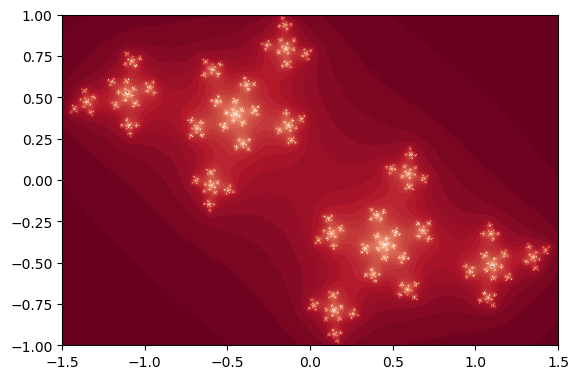

In [21]:
imshow(m, cmap="RdGy", extent=[-1.5,1.5,-1,1]);

#### Device 2: Intel HD Graphics 4000

In [22]:
device = cl.devices()[2]

OpenCL.Device(HD Graphics 4000 on Apple @0x0000000001024400)

In [23]:
@time m = julia_opencl(q, 100, device);

  0.565410 seconds (174 allocations: 32.022 MiB, 2.86% gc time)


In [24]:
@time m = julia_opencl(q, 200, device);

  0.487779 seconds (169 allocations: 32.022 MiB, 1.48% gc time)


In [25]:
@time m = julia_opencl(q, 1000, device);

  1.495333 seconds (169 allocations: 32.022 MiB, 1.04% gc time)


#### Device 3: Geforce 650M

In [26]:
device = cl.devices()[3]

OpenCL.Device(GeForce GT 650M on Apple @0x0000000001022700)

In [27]:
@time m = julia_opencl(q, 100, device);

  0.794279 seconds (169 allocations: 32.022 MiB, 0.45% gc time)


In [28]:
@time m = julia_opencl(q, 200, device);

  0.424751 seconds (169 allocations: 32.022 MiB, 1.39% gc time)


In [29]:
@time m = julia_opencl(q, 1000, device);

  1.248185 seconds (169 allocations: 32.022 MiB, 0.30% gc time)


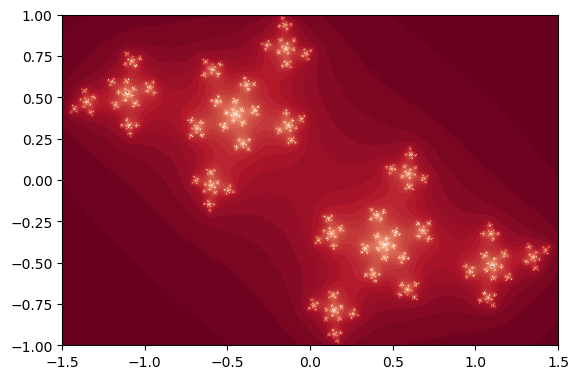

In [30]:
imshow(m, cmap="RdGy", extent=[-1.5,1.5,-1,1]);